In [36]:
import pandas as pd
import numpy as np
from math import ceil

# 📂 Cargar los archivos CSV
ventas = pd.read_csv("Ventas.csv", parse_dates=["FechaVenta"])
detalle_compras = pd.read_csv("DetalleCompra.csv", parse_dates=["FechaCompra", "FechaIngreso"])
sales_velocity = (
    ventas.groupby(["ProductoId", "NombreProducto"]).agg({"CantidadVendida": "sum"}).reset_index()
)
days = (
    pd.to_datetime(ventas["FechaVenta"]).max() - pd.to_datetime(ventas["FechaVenta"]).min()
).days
sales_velocity["mean_daily_sales"] = sales_velocity["CantidadVendida"] / days
mean_daily_sales = sales_velocity.set_index("ProductoId")["mean_daily_sales"]
display(mean_daily_sales.to_frame().T, mean_daily_sales.describe().to_frame().T)

ProductoId,58,60,61,62,63,72,75,77,79,82,...,90014,90025,90080,90081,90082,90084,90085,90086,90087,90089
mean_daily_sales,4.881356,2.101695,0.40678,2.745763,2.220339,0.322034,0.050847,15.389831,7.050847,0.050847,...,0.237288,0.20339,0.322034,0.118644,0.050847,0.033898,0.033898,0.016949,0.016949,0.457627


,count,mean,std,min,25%,50%,75%,max
mean_daily_sales,7658.0,5.425077,17.203688,0.016949,0.169492,0.830508,4.033898,483.79661


In [ ]:
# * Average Lead Time (Tiempo de reposicion)
detalle_compras["lead_time"] = (
    pd.to_datetime(detalle_compras["FechaIngreso"]) - pd.to_datetime(detalle_compras["FechaCompra"])
).dt.days
lead_time_brand = detalle_compras.groupby("ProductoId").agg({"lead_time": "mean"})
display(lead_time_brand.T, lead_time_brand.describe().T)

ProductoId,58,60,61,62,63,70,72,75,77,79,...,90080,90085,90086,90087,90088,90089,90090,90604,90609,90631
lead_time,7.758389,7.659794,8.115385,7.33157,7.324427,7.333333,8.636364,7.0,7.292162,7.270161,...,12.0,8.0,9.0,4.8,3.5,7.333333,4.5,7.384615,10.363636,9.21374


,count,mean,std,min,25%,50%,75%,max
lead_time,10663.0,7.81831,1.222808,3.0,7.277778,7.705882,8.294118,14.0


In [38]:
# * Safety Stock
max_sales_brand = ventas.groupby("ProductoId").agg({"CantidadVendida": "max"})
safety_stock = (
    max_sales_brand["CantidadVendida"]
    - sales_velocity.set_index("ProductoId")["mean_daily_sales"]
)
display(safety_stock.to_frame().T, safety_stock.describe().to_frame().T)
# * notice there are negatives to fix this problem we will just set them to 0
safety_stock[safety_stock < 0] = 0

ProductoId,58,60,61,62,63,72,75,77,79,82,...,90014,90025,90080,90081,90082,90084,90085,90086,90087,90089
0,2.118644,0.898305,11.59322,0.254237,1.779661,2.677966,0.949153,-7.389831,-2.050847,2.949153,...,11.762712,9.79661,7.677966,5.881356,1.949153,0.966102,1.966102,0.983051,0.983051,11.542373


,count,mean,std,min,25%,50%,75%,max
0,7658.0,6.12794,16.949081,-356.79661,1.508475,3.762712,9.525424,407.966102


El análisis ABC es un método utilizado para clasificar productos, clientes o cualquier otro elemento en función de su valor relativo en términos de ventas, demanda, frecuencia o cualquier otra métrica relevante. Es un enfoque de segmentación que permite identificar y priorizar los elementos que tienen un impacto más significativo en un negocio.

El análisis ABC se basa en la regla 80/20 (también conocida como el Principio de Pareto), que sugiere que aproximadamente el 80% de los resultados provienen del 20% de los esfuerzos. En el caso del análisis de ventas, esto podría significar que una pequeña proporción de productos (o marcas, clientes, etc.) genera la mayor parte de las ventas.

Clasificación en tres grupos (A, B y C): Los productos (marcas) se clasifican en tres categorías según su cantidad de ventas (SalesQuantity):

Grupo C: Marcas con ventas menores a 100 unidades.
Grupo B: Marcas con ventas entre 100 y 1,000 unidades.
Grupo A: Marcas con ventas entre 1,000 y 30,000 unidades.
La clasificación se realiza con pd.cut(), lo cual divide los datos en intervalos según los límites definidos en la lista bins.

In [39]:
ABC = (
    ventas.groupby("ProductoId")
    .agg({"CantidadVendida": "sum"})
    .sort_values("CantidadVendida", ascending=False)
)
display(
    "Top 5 Demand",
    ABC.head(),
    "Bottom 5 Demand",
    ABC.tail(),
    "describe data",
    ABC.describe().T,
)
bins = [0, 100, 1000, 30000]
labels = ["C: <100", "B: 100-1k", "A: 1k-30k"]
ABC['bin'] = pd.cut(ABC["CantidadVendida"], bins, labels=labels)

'Top 5 Demand'

,CantidadVendida
ProductoId,
8111,28544
1892,23121
4261,20226
3606,19200
5111,18411


'Bottom 5 Demand'

,CantidadVendida
ProductoId,
17576,1
4308,1
4260,1
4164,1
5114,1


'describe data'

,count,mean,std,min,25%,50%,75%,max
CantidadVendida,7658.0,320.079525,1015.017597,1.0,10.0,49.0,238.0,28544.0


Grupo A: Marcas de alto impacto que merecen atención especial en cuanto a estrategias de ventas, marketing o stock.<br>
Grupo B: Marcas intermedias que todavía son importantes, pero no tanto como las del grupo A.<br>
Grupo C: Marcas de bajo impacto, que podrían ser consideradas para eliminar, reducir inventario o invertir menos.<br>
Es una técnica útil para tomar decisiones más informadas sobre dónde concentrar esfuerzos y recursos en un negocio.

In [40]:
# * Reorder Point Analysis
RPA = (lead_time_brand['lead_time'] * mean_daily_sales) + safety_stock
RPA.name = "ReorderPoint"
RPA.dropna(inplace=True)
RPA = RPA.apply(lambda x: ceil(x)).to_frame()
RPA['ABC'] = ABC['bin']
display(RPA.T,RPA.describe().T)

ProductoId,58,60,61,62,63,72,75,77,79,82,...,90010,90011,90012,90013,90014,90080,90085,90086,90087,90089
ReorderPoint,40,17,15,21,19,6,2,113,52,4,...,3,14,8,15,14,12,3,2,2,15
ABC,B: 100-1k,B: 100-1k,C: <100,B: 100-1k,B: 100-1k,C: <100,C: <100,B: 100-1k,B: 100-1k,C: <100,...,C: <100,C: <100,C: <100,C: <100,C: <100,C: <100,C: <100,C: <100,C: <100,C: <100


,count,mean,std,min,25%,50%,75%,max
ReorderPoint,7146.0,52.479429,136.521855,2.0,6.0,16.0,46.0,3687.0


El punto de reorden (Reorder Point, ROP) es un concepto clave en la gestión de inventarios que indica el nivel de inventario en el que una empresa debe realizar un nuevo pedido para evitar quedarse sin existencias de un producto. Es esencial para garantizar que el stock se mantenga disponible sin tener un exceso de inventario.

In [41]:
# Crear un nuevo DataFrame con ProductoID, ReorderPoint y ABC
ABC_final = RPA
ABC_final

,ReorderPoint,ABC
ProductoId,,
58,40,B: 100-1k
60,17,B: 100-1k
61,15,C: <100
62,21,B: 100-1k
63,19,B: 100-1k
...,...,...
90080,12,C: <100
90085,3,C: <100
90086,2,C: <100


In [42]:
RPA_reset = RPA.reset_index()

In [43]:
RPA_nuevo=RPA

In [44]:
RPA_final = RPA_reset[['ProductoId', 'ReorderPoint', 'ABC']]
RPA_final

,ProductoId,ReorderPoint,ABC
0,58,40,B: 100-1k
1,60,17,B: 100-1k
2,61,15,C: <100
3,62,21,B: 100-1k
4,63,19,B: 100-1k
...,...,...,...
7141,90080,12,C: <100
7142,90085,3,C: <100
7143,90086,2,C: <100
7144,90087,2,C: <100


Text(0, 0.5, 'Frequency')

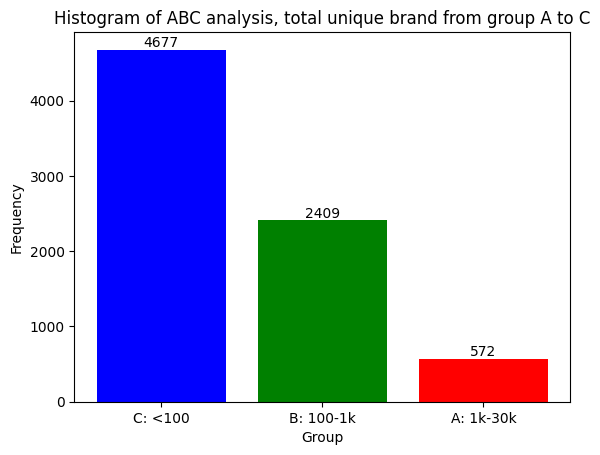

In [45]:
import matplotlib.pyplot as plt
plt.bar(ABC['bin'].value_counts().index, ABC['bin'].value_counts().values, color=['blue','green','red'])
for i, value in enumerate(ABC['bin'].value_counts().values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.title('Histogram of ABC analysis, total unique brand from group A to C')
plt.xlabel('Group')
plt.ylabel('Frequency')

In [46]:
# Resetear el índice para que 'ProductoId' se convierta en una columna normal
lead_time_brand = lead_time_brand.reset_index()

# Verifica cómo se ve después de resetear el índice
print(lead_time_brand.head())

   ProductoId  lead_time
0          58   7.758389
1          60   7.659794
2          61   8.115385
3          62   7.331570
4          63   7.324427


In [47]:
# Combinación de ambos datasets usando la columna 'ProductoId'
ABC_final = pd.merge(RPA_final, lead_time_brand[['ProductoId', 'lead_time']], on='ProductoId', how='left')

# Verificar el resultado
print(ABC_final.head())

   ProductoId  ReorderPoint        ABC  lead_time
0          58            40  B: 100-1k   7.758389
1          60            17  B: 100-1k   7.659794
2          61            15    C: <100   8.115385
3          62            21  B: 100-1k   7.331570
4          63            19  B: 100-1k   7.324427


In [13]:
ABC_final.to_csv("ABC_Analysis2.csv", index=False)

**USANDO UN ENFOQUE MAS DINAMICO**

Sin embargo usaremos el anterior porque se ve mas marcada la diferencia entre los grupos.

In [48]:
# Calcular el valor total de ventas por producto
ventas["ValorTotal"] = ventas["CantidadVendida"] * ventas["PrecioUnitario"]

ABC2 = (
    ventas.groupby("ProductoId")
    .agg({"ValorTotal": "sum"})
    .sort_values("ValorTotal", ascending=False)
)

# Calcular la contribución acumulativa al valor total
ABC2["% acumulado"] = ABC2["ValorTotal"].cumsum() / ABC2["ValorTotal"].sum() * 100

# Clasificar según el criterio ABC basado en porcentaje
def clasificar_abc(porcentaje):
    if porcentaje <= 80:
        return "A"
    elif porcentaje <= 95:
        return "B"
    else:
        return "C"

ABC2["Categoria"] = ABC2["% acumulado"].apply(clasificar_abc)

# Mostrar el resultado
display(ABC2.head(), ABC2.describe().T)


,ValorTotal,% acumulado,Categoria
ProductoId,,,
4261,444810.74,1.342242,A
3545,357759.17,2.421802,A
1233,344712.22,3.461991,A
8068,288135.11,4.331455,A
3405,275162.97,5.161776,A


,count,mean,std,min,25%,50%,75%,max
ValorTotal,7658.0,4327.419077,14205.480602,0.980000,191.880000,935.120000,3654.38500,444810.74
% acumulado,7658.0,88.795098,16.946561,1.342242,85.359416,96.748481,99.53651,100.00


C:\Users\mariu\AppData\Local\Temp\ipykernel_11772\3031865807.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categoria_counts.index, y=categoria_counts.values, palette=["red", "orange", "green"])


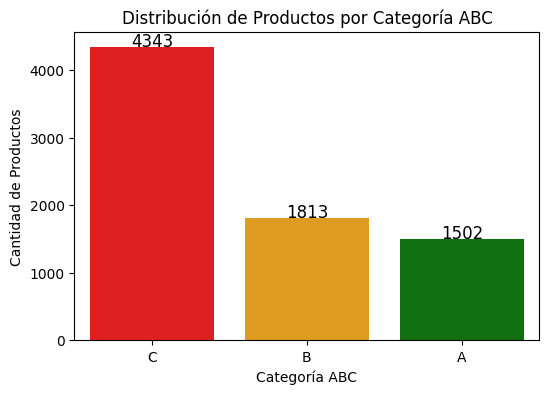

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar la cantidad de productos en cada categoría ABC
categoria_counts = ABC2["Categoria"].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(6, 4))
sns.barplot(x=categoria_counts.index, y=categoria_counts.values, palette=["red", "orange", "green"])

# Etiquetas y título
plt.xlabel("Categoría ABC")
plt.ylabel("Cantidad de Productos")
plt.title("Distribución de Productos por Categoría ABC")

# Mostrar los valores en las barras
for i, v in enumerate(categoria_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.show()
